### NOAA sea level data 2016

https://tidesandcurrents.noaa.gov/map/index.html

Stations I'm looking at:

|Station|Lat|Lon|
|:--:|:--:|:-:|
|La Jolla     |32° 52.0 N |117° 15.4 W |
|Los Angeles  |33° 43.2 N |118° 16.4 W | 
|Santa Monica |34° 0.5 N  |118° 30.0 W |
|Santa Barbara|34° 24.2 N |119° 41.6 W |
|Port San Luis|35° 10.1 N |120° 45.3 W |

![](figures/NOAA_stations.png)

**Columns**: "Date","Time (GMT)","Predicted (m)","Preliminary (m)","Verified (m)"

In [1]:
import cmocean as cmo
import datetime as dt
from matplotlib.dates import date2num
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import ssh_tools as ssht # my module
import tide_tools as tidet # my module
from scipy import signal

import warnings
warnings.filterwarnings('ignore')

In [127]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [18]:
col_names = ["Date","Time","Predicted","Preliminary","Verified"]
stations=['LaJolla','LosAngeles','SantaMonica','SantaBarbara','PortSanLuis']
st_ids = ['9410230','9410660','9410840','9411340','9412110']
months = ['jan','feb','mar','apr','may','jun','jul','aug']

### Full-length time series

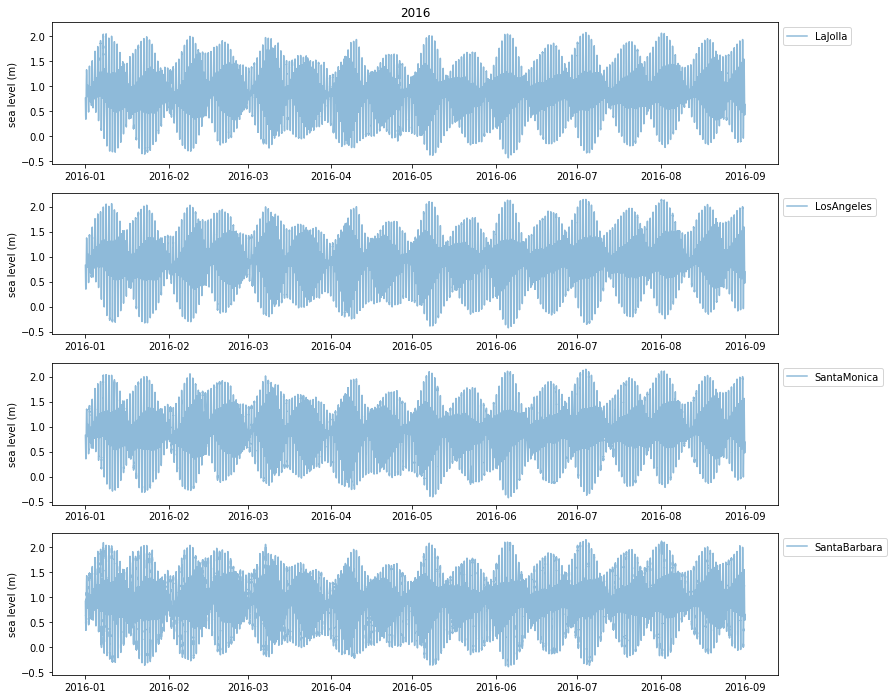

In [3]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(13,12), sharey=True)
axs = [ax1,ax2,ax3,ax4]

for station, st_id, ax in zip(stations, st_ids, axs):
    df = pd.DataFrame(columns=col_names)
    for month in months:
        directory = '../NOAA-seaLevel/' + station 
        filename = directory + '/CO-OPS_' + st_id + '_met_' + month + '.csv'
        data = pd.read_csv(filename, parse_dates=[['Date', 'Time']], names=col_names) 
        data['datetime'] = pd.to_datetime(data['Date_Time'][1:], format='%Y/%m/%d %H:%M')
        df = pd.concat([df, data])
    data_new = df.set_index('datetime')
    ssh = pd.to_numeric(data_new['Verified'], errors='coerce')
    ax.plot(data_new.index, ssh, alpha=0.5, label=station)
        
for ax, month in zip(axs, months):
    ax.set_xlabel('')
    ax.set_ylabel('sea level (m)')
    ax.legend(bbox_to_anchor=(1,1))
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
  
ax1.set_title('2016')    
plt.show()

### De-tided timeseries

* Make one long time series with all the months
* Use my functions in ssh_tools to remove 37 main consituents (overkill, probably ok with just )

#### Try out one month, one station

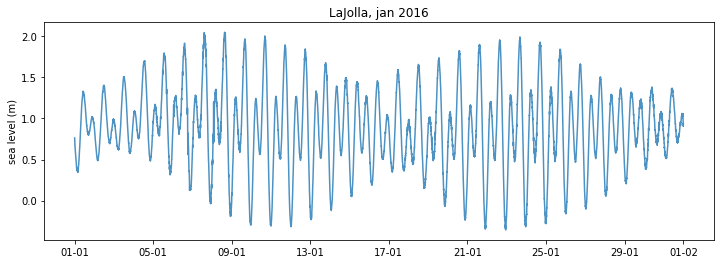

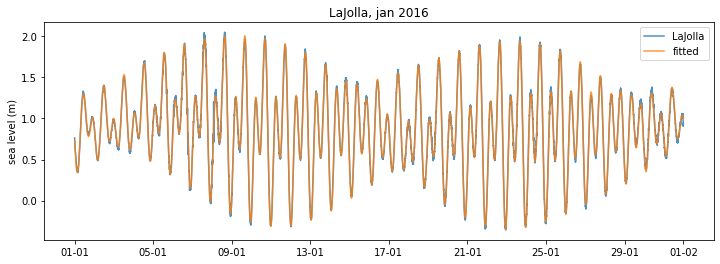

In [4]:
omegas = tidet.define_constituents()

# select 1 month, 1 station
st_id = st_ids[0]
month = months[0]
station = stations[0]

# read data
directory = '../NOAA-seaLevel/' + station 
filename = directory + '/CO-OPS_' + st_id + '_met_' + month + '.csv'
data = pd.read_csv(filename, parse_dates=[['Date', 'Time']], names=col_names) 
data['datetime'] = pd.to_datetime(data['Date_Time'][1:], format='%Y/%m/%d %H:%M')
data_new = data.set_index('datetime')
ssh = pd.to_numeric(data_new['Verified'], errors='coerce')

# plot
fig,ax = plt.subplots(1,1, figsize=(12,4))
ax.plot(ssh, alpha=0.8, label=station)
ax.set_ylabel('sea level (m)') 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
ax.set_title('%s, %s 2016' %(station,month))
 
# Time vector of seconds (generate timedelta vector and convert to seconds)
T = (data['datetime'][1:]-data['datetime'][1])/ np.timedelta64(1, 's')
T[1] = 1

A, level = tidet.fit_harmonics(omegas, T, ssh[1:])

# Plot
fig,ax = plt.subplots(1,1, figsize=(12,4))
ax.plot(ssh.index, ssh, alpha=0.8, label=station)
ax.plot(ssh.index[1:], np.squeeze(level), alpha=0.8, label='fitted')
ax.set_ylabel('sea level (m)') 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
ax.set_title('%s, %s 2016' %(station,month))
ax.legend()

#### De-tide all

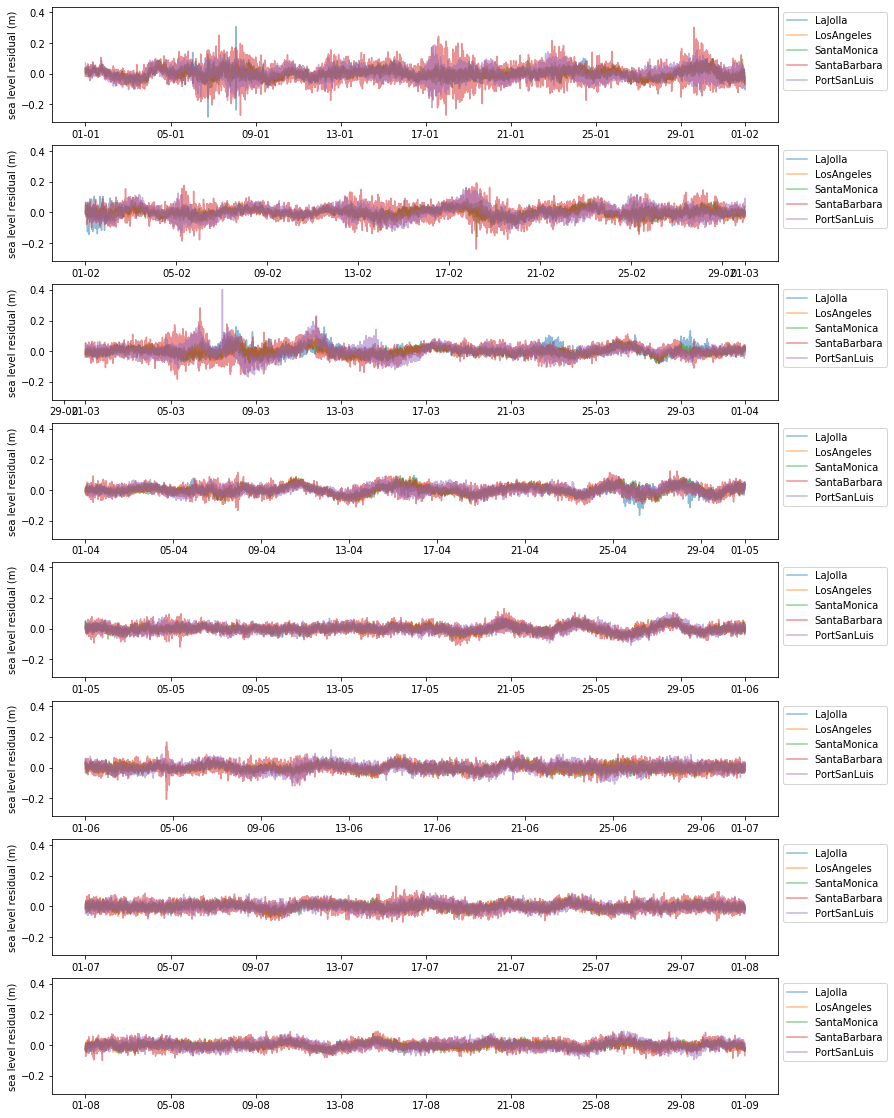

In [5]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = plt.subplots(8,1, figsize=(13,20), sharey=True)
axs = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]

omegas = tidet.define_constituents()

for station, st_id in zip(stations, st_ids):
    for month, ax in zip(months, axs):
        # read data
        directory = '../NOAA-seaLevel/' + station 
        filename = directory + '/CO-OPS_' + st_id + '_met_' + month + '.csv'
        data = pd.read_csv(filename, parse_dates=[['Date', 'Time']], names=col_names) 
        data['datetime'] = pd.to_datetime(data['Date_Time'][1:], format='%Y/%m/%d %H:%M')
        data_new = data.set_index('datetime')
        ssh = pd.to_numeric(data_new['Verified'], errors='coerce')
 
        # Time vector of seconds (generate timedelta vector and convert to seconds)
        T = (data['datetime'][1:]-data['datetime'][1])/ np.timedelta64(1, 's')
        T[1] = 1
        A, level = tidet.fit_harmonics(omegas, T, ssh[1:])

        # Plot
        ax.plot(ssh.index[1:],ssh.values[1:]-np.squeeze(level), alpha=0.5, label=station)

for ax in axs:
    ax.set_ylabel('sea level residual (m)') 
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
    ax.legend(bbox_to_anchor=(1,1))

#### Residual spectra 

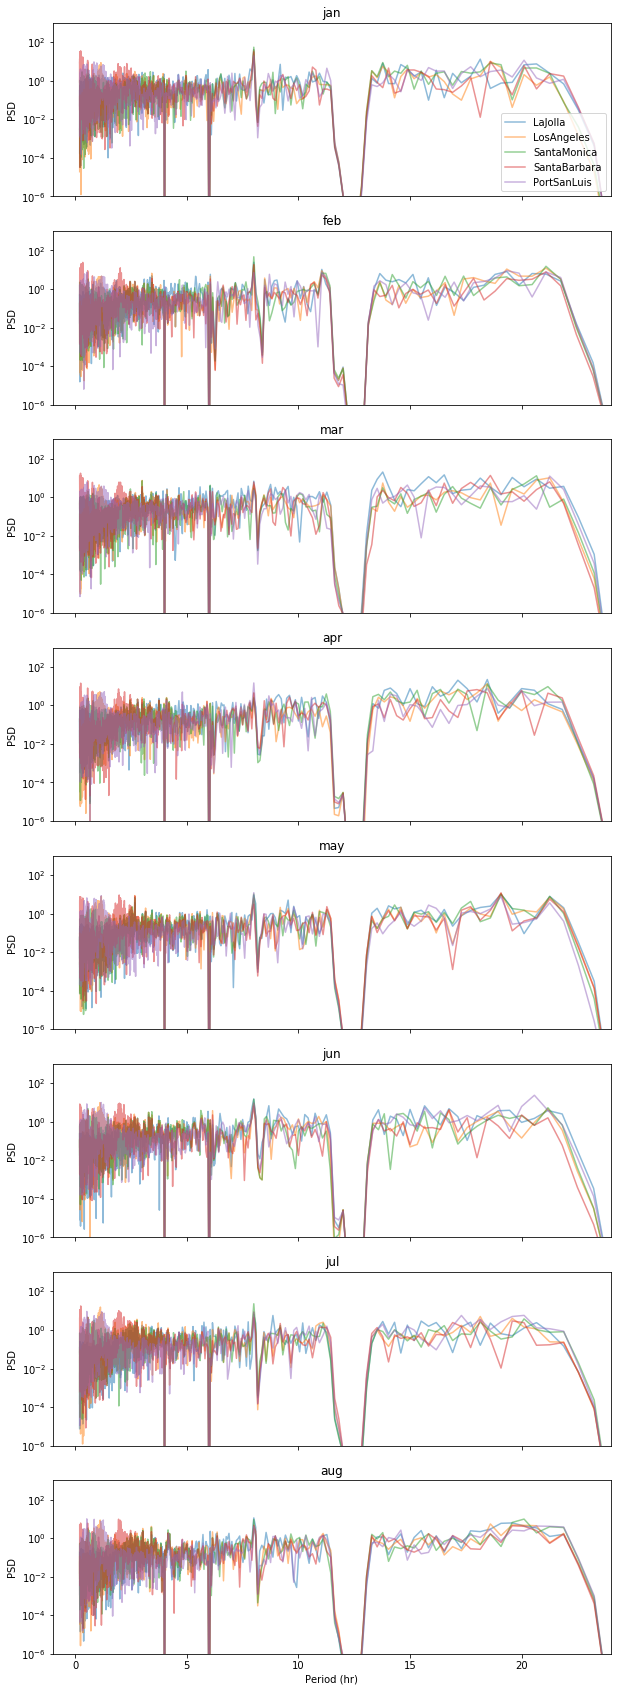

In [14]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = plt.subplots(8,1, figsize=(10,30), sharey=True, sharex=True)
axs = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]

omegas = tidet.define_constituents()

for station, st_id in zip(stations, st_ids):
    for month, ax in zip(months, axs):
        # read data
        directory = '../NOAA-seaLevel/' + station 
        filename = directory + '/CO-OPS_' + st_id + '_met_' + month + '.csv'
        data = pd.read_csv(filename, parse_dates=[['Date', 'Time']], names=col_names) 
        data['datetime'] = pd.to_datetime(data['Date_Time'][1:], format='%Y/%m/%d %H:%M')
        data_new = data.set_index('datetime')
        ssh = pd.to_numeric(data_new['Verified'], errors='coerce')
 
        # Time vector of seconds (generate timedelta vector and convert to seconds)
        T = (data['datetime'][1:]-data['datetime'][1])/ np.timedelta64(1, 's')
        T[1] = 1
        A, level = tidet.fit_harmonics(omegas, T, ssh[1:])
        
        samp_freq = 1/(T[4]-T[3])
        freq_fit, Pden_fit = signal.periodogram(ssh[1:].values-np.squeeze(level), samp_freq, 
                                                window='boxcar',detrend='constant')
   
        # Plot
        ax.semilogy((1/freq_fit)/3600, Pden_fit,'-',alpha=0.5, label=station)

for ax, month in zip(axs,months):
    ax.set_xlim(-1,24)
    ax.set_ylim(1E-6,1E3)
    ax.set_ylabel('PSD')
    ax.set_title(month)

ax8.set_xlabel('Period (hr)')
ax1.legend()

#### Sea level obs. spectra

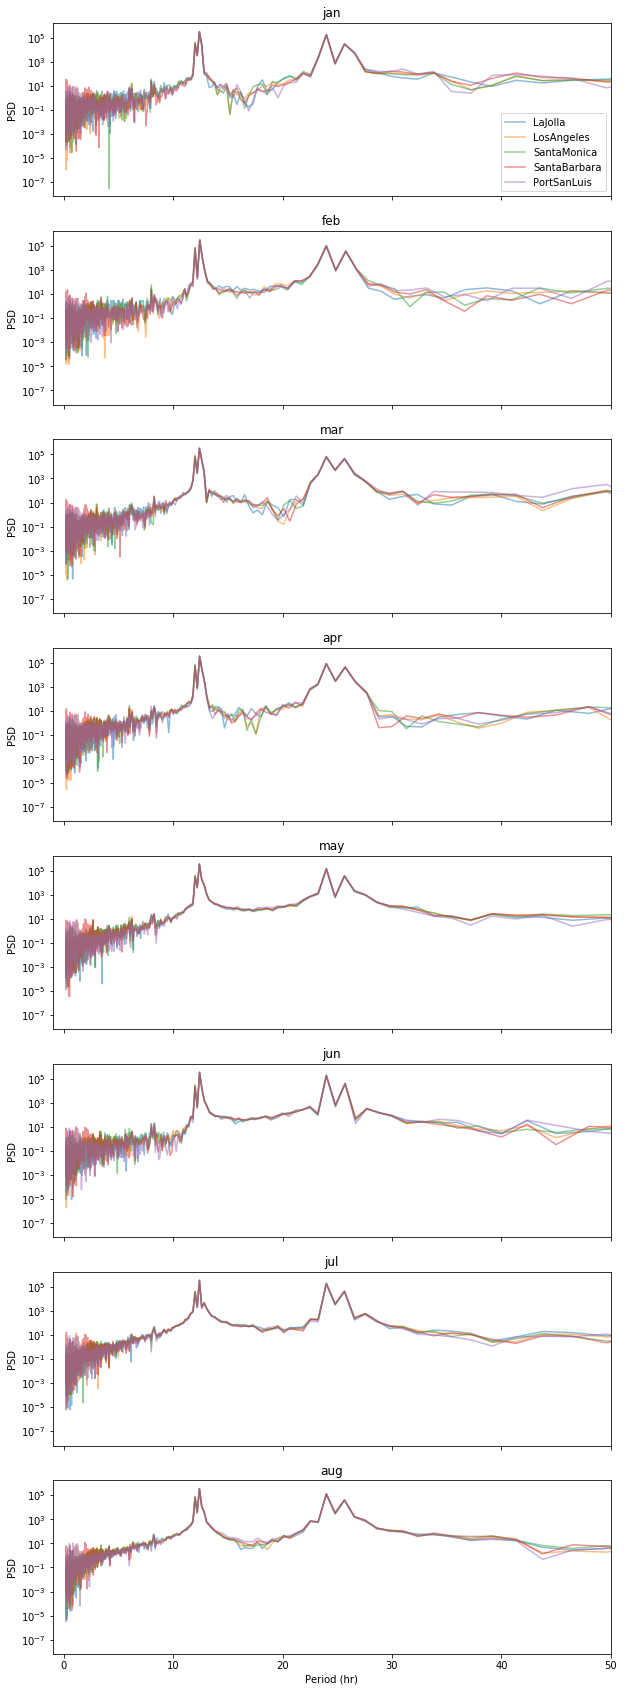

In [13]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = plt.subplots(8,1, figsize=(10,30), sharey=True, sharex=True)
axs = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]

omegas = tidet.define_constituents()

for station, st_id in zip(stations, st_ids):
    for month, ax in zip(months, axs):
        # read data
        directory = '../NOAA-seaLevel/' + station 
        filename = directory + '/CO-OPS_' + st_id + '_met_' + month + '.csv'
        data = pd.read_csv(filename, parse_dates=[['Date', 'Time']], names=col_names) 
        data['datetime'] = pd.to_datetime(data['Date_Time'][1:], format='%Y/%m/%d %H:%M')
        data_new = data.set_index('datetime')
        ssh = pd.to_numeric(data_new['Verified'], errors='coerce')
 
        # Time vector of seconds (generate timedelta vector and convert to seconds)
        T = (data['datetime'][1:]-data['datetime'][1])/ np.timedelta64(1, 's')
        T[1] = 1
        A, level = tidet.fit_harmonics(omegas, T, ssh[1:])
        
        samp_freq = 1/(T[4]-T[3])
        freq_fit, Pden_fit = signal.periodogram(ssh[1:].values, samp_freq,window='boxcar', detrend='constant')
   
        # Plot
        ax.semilogy((1/freq_fit)/3600, Pden_fit,'-',alpha=0.5, label=station)

for ax, month in zip(axs,months):
    ax.set_xlim(-1,50)
    #ax.set_ylim(1E-6,1E3)
    ax.set_ylabel('PSD')
    ax.set_title(month)

ax8.set_xlabel('Period (hr)')
ax1.legend()

### Wavelets

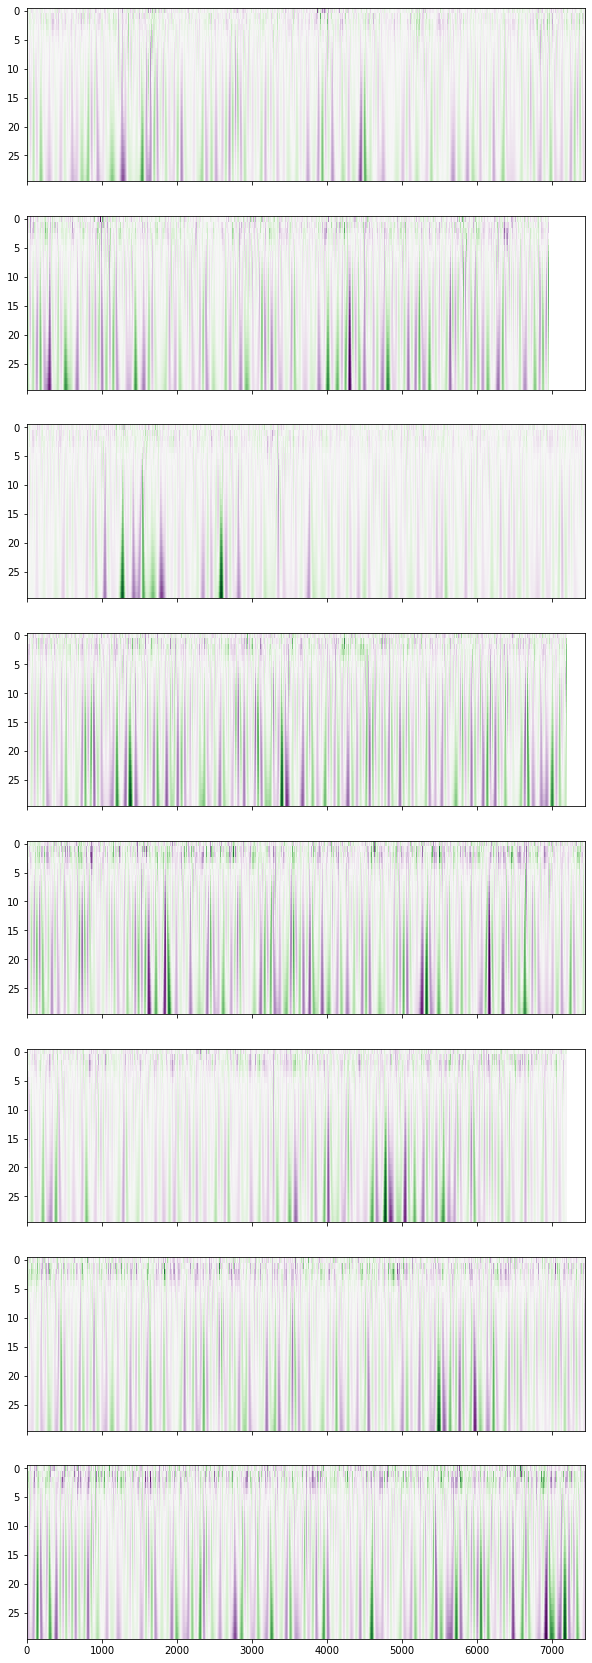

In [23]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = plt.subplots(8,1, figsize=(10,30), sharey=True, sharex=True)
axs = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]

omegas = tidet.define_constituents()

for station, st_id in zip(stations, st_ids):
    for month, ax in zip(months, axs):
        # read data
        directory = '../NOAA-seaLevel/' + station 
        filename = directory + '/CO-OPS_' + st_id + '_met_' + month + '.csv'
        data = pd.read_csv(filename, parse_dates=[['Date', 'Time']], names=col_names) 
        data['datetime'] = pd.to_datetime(data['Date_Time'][1:], format='%Y/%m/%d %H:%M')
        data_new = data.set_index('datetime')
        ssh = pd.to_numeric(data_new['Verified'], errors='coerce')
 
        # Detide: Time vector of seconds (generate timedelta vector and convert to seconds)
        T = (data['datetime'][1:]-data['datetime'][1])/ np.timedelta64(1, 's')
        T[1] = 1
        A, level = tidet.fit_harmonics(omegas, T, ssh[1:])
        
        # Wavelet
        widths = np.arange(1, 31)
        cwtmatr = signal.cwt(ssh[1:].values-np.squeeze(level), signal.ricker, widths)

        # Plot
        ax.imshow(cwtmatr, cmap='PRGn', aspect='auto', vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())


In [21]:
stations[0]

'LaJolla'